# LanceDB Feature Engineering quickstart demo

In this example, we'll take some images, create embeddings and captions (if you have a gpu) to demonstrate a feature engineering workflow.

Prerequisites:
* Python 3.10.x
* uv package manager

In [1]:
# specify a path for data to be stored.  Can be on the local filesystem or object store
import tempfile
GENEVA_DB_PATH=tempfile.mkdtemp(prefix="quickstart-local-")
NUM_IMAGES=75
GENEVA_DB_PATH

'/tmp/quickstart-local-8_w1gfcu'

In [2]:
%load_ext autoreload
%autoreload 2

## dev mode 
#import sys
#sys.path.append("../src")

## local install 
# ! uv pip install -e .. --extra-index-url https://pypi.fury.io/lancedb

## install from pypi repos
! uv pip install geneva

In [3]:
# dump more logging info
import logging
import sys
# logging.basicConfig(level=logging.INFO, stream=sys.stderr, force=True)
# logging.basicConfig(level=logging.DEBUG, stream=sys.stderr, force=True)
logging.basicConfig(level=logging.WARNING, stream=sys.stderr, force=True)

In [4]:
# geneva version should be >= 0.1.23 
import geneva
import pyarrow as pa
import lance
import lancedb
print(f"geneva {geneva.__version__} lancedb {lancedb.__version__}")

DEBUG:asyncio:Using selector: EpollSelector


geneva 0.1.29 lancedb 0.23.0


In [5]:
# verify that this machine has GPU
import torch

has_gpu = torch.cuda.is_available()

print("CUDA available:", has_gpu)
if has_gpu:
    print("GPU name:", torch.cuda.get_device_name(0))
    print("GPU memory (MB):", torch.cuda.get_device_properties(0).total_memory / 1024**2)


CUDA available: True
GPU name: NVIDIA RTX 4000 Ada Generation Laptop GPU
GPU memory (MB): 12281.5


## Let's load some image data

! uv pip install datasets==3.5.0 pillow  dill==0.3.7  --upgrade
! uv pip install fsspec --upgrade

In [6]:
# Convert a hugging face dataset to lance dataset is easy
import pyarrow as pa
from datasets import load_dataset
# import lance
import shutil
import io
from geneva.tqdm import tqdm 

shutil.rmtree(GENEVA_DB_PATH, ignore_errors=True)

def load_images(frag_size:int = 25):
    dataset = load_dataset("timm/oxford-iiit-pet", split=f"train[:{NUM_IMAGES}]")
    batch = []
    for row in tqdm(dataset):
        buf = io.BytesIO()
        row["image"].save(buf, format="png")
        batch.append({"image": buf.getvalue(), "label": row["label"], "image_id":row["image_id"], "label_cat_dog":row["label_cat_dog"]})
        if len(batch) >= frag_size:
            yield pa.RecordBatch.from_pylist(batch)
            batch = []

    if len(batch):
        yield pa.RecordBatch.from_pylist(batch)
db = geneva.connect(GENEVA_DB_PATH)
# tbl = db.create_table("images", load_images(), mode="overwrite")
# db.table_names()

INFO:datasets:PyTorch version 2.7.1 available.
INFO:datasets:Polars version 1.26.0 available.


In [7]:
first = True
for batch in load_images():
    if first:        
        tbl = db.create_table("images", batch, mode="overwrite")
        first = False
    else:
        tbl.add(batch)
    
db.table_names()

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /datasets/timm/oxford-iiit-pet/resolve/main/README.md HTTP/1.1" 307 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /api/resolve-cache/datasets/timm/oxford-iiit-pet/089695c834a7deb60505b7cc506672db1c31a6aa/README.md HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /datasets/timm/oxford-iiit-pet/resolve/089695c834a7deb60505b7cc506672db1c31a6aa/oxford-iiit-pet.py HTTP/1.1" 404 0
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): s3.amazonaws.com:443
DEBUG:urllib3.connectionpool:https://s3.amazonaws.com:443 "HEAD /datasets.huggingface.co/datasets/datasets/timm/oxford-iiit-pet/timm/oxford-iiit-pet.py HTTP/1.1" 404 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "GET /api/datasets/timm/oxford-iiit-pet/revision/089695c834a7deb60505b7cc506672db1c31a6aa HTTP/1.1" 200 2742
DEBUG:urllib

  0%|          | 0/75 [00:00<?, ?it/s]

[2025-06-29T14:53:05Z WARN  lance::dataset::write::insert] No existing dataset at /tmp/quickstart-local-8_w1gfcu/images.lance, it will be created
DEBUG:PIL.TiffImagePlugin:tag: Make (271) - type: string (2) Tag Location: 22 - Data Location: 242 - value: b'EASTMAN KODAK COMPANY\x00'
DEBUG:PIL.TiffImagePlugin:tag: Model (272) - type: string (2) Tag Location: 34 - Data Location: 264 - value: <table: 33 bytes>
DEBUG:PIL.TiffImagePlugin:tag: Orientation (274) - type: short (3) - value: b'\x01\x00'
DEBUG:PIL.TiffImagePlugin:tag: XResolution (282) - type: rational (5) Tag Location: 58 - Data Location: 298 - value: b'\xe6\x00\x00\x00\x01\x00\x00\x00'
DEBUG:PIL.TiffImagePlugin:tag: YResolution (283) - type: rational (5) Tag Location: 70 - Data Location: 306 - value: b'\xe6\x00\x00\x00\x01\x00\x00\x00'
DEBUG:PIL.TiffImagePlugin:tag: ResolutionUnit (296) - type: short (3) - value: b'\x02\x00'
DEBUG:PIL.TiffImagePlugin:tag: YCbCrPositioning (531) - type: short (3) - value: b'\x01\x00'
DEBUG:PIL.Ti

['images']

[2025-06-29T14:53:08Z WARN  lance::dataset::scanner] nprobes is not set because nearest has not been called yet
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'iCCP' 41 2609
DEBUG:PIL.PngImagePlugin:iCCP profile name b'ICC Profile'
DEBUG:PIL.PngImagePlugin:Compression method 0
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 2662 65536
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'iCCP' 41 2609
DEBUG:PIL.PngImagePlugin:iCCP profile name b'ICC Profile'
DEBUG:PIL.PngImagePlugin:Compression method 0
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 2662 65536
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 65536
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 65536
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 65536
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 65536
DEBUG:PIL.

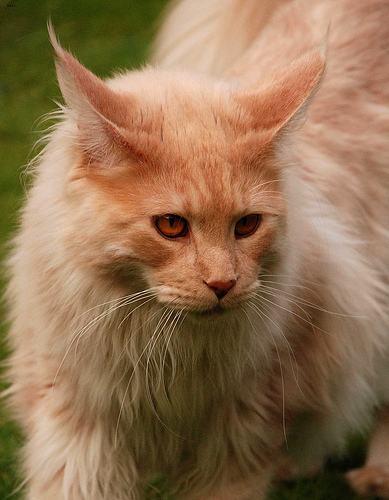

In [8]:
import io
from PIL import Image

df = tbl.to_arrow().to_pandas()
all_images = []
for b in df['image']:
    image_stream = io.BytesIO(b)
    image = Image.open(image_stream)
    # display(image)
    all_images.append(image)

all_images[0]

# Let's add some light weight features 
Let's add the dimensions of the image as a column

! uv pip install ray==2.44.1 kubernetes

In [9]:
# Verify that ray works
import ray
import os

try:
    ray.shutdown()
except:
    pass
ray.init()

DEBUG:filelock:Attempting to acquire lock 140091034989280 on /tmp/ray/session_2025-06-29_07-53-08_951819_2266976/node_ip_address.json.lock
DEBUG:filelock:Lock 140091034989280 acquired on /tmp/ray/session_2025-06-29_07-53-08_951819_2266976/node_ip_address.json.lock
DEBUG:filelock:Attempting to release lock 140091034989280 on /tmp/ray/session_2025-06-29_07-53-08_951819_2266976/node_ip_address.json.lock
DEBUG:filelock:Lock 140091034989280 released on /tmp/ray/session_2025-06-29_07-53-08_951819_2266976/node_ip_address.json.lock
DEBUG:filelock:Attempting to acquire lock 140099693932464 on /tmp/ray/session_2025-06-29_07-53-08_951819_2266976/ports_by_node.json.lock
DEBUG:filelock:Lock 140099693932464 acquired on /tmp/ray/session_2025-06-29_07-53-08_951819_2266976/ports_by_node.json.lock
DEBUG:filelock:Attempting to release lock 140099693932464 on /tmp/ray/session_2025-06-29_07-53-08_951819_2266976/ports_by_node.json.lock
DEBUG:filelock:Lock 140099693932464 released on /tmp/ray/session_2025-06

RayContext(dashboard_url='127.0.0.1:8265', python_version='3.10.16', ray_version='2.44.1', ray_commit='daca7b2b1a950dc7f731e34e74c76ae383794ffe')

(run_ray_add_column_remote pid=2267689) [2025-06-29T14:53:19Z WARN  lance::dataset::transaction] Building manifest with DataReplacement operation. This operation is not stable yet, please use with caution.
(run_ray_add_column_remote pid=2267689) [2025-06-29T14:53:19Z WARN  lance::dataset::transaction] Building manifest with DataReplacement operation. This operation is not stable yet, please use with caution.
(run_ray_add_column_remote pid=2267689) [2025-06-29T14:53:19Z WARN  lance::dataset::transaction] Building manifest with DataReplacement operation. This operation is not stable yet, please use with caution.
(run_ray_add_column_remote pid=2267689) [2025-06-29T14:53:23Z WARN  lance::dataset::transaction] Building manifest with DataReplacement operation. This operation is not stable yet, please use with caution.
(run_ray_add_column_remote pid=2267689) [2025-06-29T14:53:24Z WARN  lance::dataset::transaction] Building manifest with DataReplacement operation. This operation is not stable 

(ApplierActor(applier=CheckpointingApplier(checkpoint_store=<geneva.checkpoint.LanceCheckpointStore object at 0x7fab0ffd3880>, map_task=BackfillUDFTask(udfs={'embedding': UDF(func=<__main__.GenEmbeddings object at 0x7fab0ffd2e90>, name='GenEmbeddings', cuda=False, num_cpus=1.0, memory=None, batch_size=None, input_columns=['image'], data_type=FixedSizeListType(fixed_size_list<item: float>[512]), version='0.1', checkpoint_key='GenEmbeddings:0.1', field_metadata={})}, where=None), error_logger=CheckpointStoreErrorLogger(job_id='1cad524fb67343779b555699e5a7aaca', checkpoint_store=<geneva.checkpoint.LanceCheckpointStore object at 0x7fab0ffd3880>), batch_applier=SimpleApplier())) pid=2271015) Ray worker sees torch.cuda.is_available() == False
(ApplierActor(applier=CheckpointingApplier(checkpoint_store=<geneva.checkpoint.LanceCheckpointStore object at 0x7fab0ffd3880>, map_task=BackfillUDFTask(udfs={'embedding': UDF(func=<__main__.GenEmbeddings object at 0x7fab0ffd2e90>, name='GenEmbeddings', 

(run_ray_add_column_remote pid=2267689) [2025-06-29T14:54:08Z WARN  lance::dataset::transaction] Building manifest with DataReplacement operation. This operation is not stable yet, please use with caution.
(run_ray_add_column_remote pid=2267689) [2025-06-29T14:54:08Z WARN  lance::dataset::transaction] Building manifest with DataReplacement operation. This operation is not stable yet, please use with caution.
(ApplierActor(applier=CheckpointingApplier(checkpoint_store=<geneva.checkpoint.LanceCheckpointStore object at 0x7f64fe6a7880>, map_task=BackfillUDFTask(udfs={'caption_blip': UDF(func=<function caption_udf at 0x7f64fe6b7910>, name='caption_udf', cuda=True, num_cpus=1.0, memory=None, batch_size=None, input_columns=['image'], data_type=DataType(string), version='blip', checkpoint_key='caption_udf:blip', field_metadata={})}, where=None), error_logger=CheckpointStoreErrorLogger(job_id='602f0481a6f842248d4497134d2b4990', checkpoint_store=<geneva.checkpoint.LanceCheckpointStore object at 

(autoscaler +1m36s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(autoscaler +1m36s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +2m11s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +2m46s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +3m21s) Warning: The following resource request cannot be scheduled right now: {'

(run_ray_add_column_remote pid=2267689) [2025-06-29T14:58:00Z WARN  lance::dataset::transaction] Building manifest with DataReplacement operation. This operation is not stable yet, please use with caution.
(run_ray_add_column_remote pid=2267689) [2025-06-29T14:58:01Z WARN  lance::dataset::transaction] Building manifest with DataReplacement operation. This operation is not stable yet, please use with caution.


(autoscaler +5m6s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(ApplierActor(applier=CheckpointingApplier(checkpoint_store=<geneva.checkpoint.LanceCheckpointStore object at 0x7f2a98293880>, map_task=BackfillUDFTask(udfs={'caption_blip_v2': UDF(func=<__main__.GenCaption object at 0x7f2a98292f80>, name='GenCaption', cuda=True, num_cpus=1.0, memory=None, batch_size=None, input_columns=['image'], data_type=DataType(string), version='71f73a35d8db496f4a515c89ad6f62af', checkpoint_key='GenCaption:71f73a35d8db496f4a515c89ad6f62af', field_metadata={})}, where=None), error_logger=CheckpointStoreErrorLogger(job_id='1f35a6af58b54987bcd621044e5d3f06', checkpoint_store=<geneva.checkpoint.LanceCheckpointStore object at 0x7f2a98293880>), batch_applier=SimpleApplier())) pid=2275825) Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a 

(autoscaler +5m41s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(run_ray_add_column_remote pid=2267689) [2025-06-29T14:59:03Z WARN  lance::dataset::transaction] Building manifest with DataReplacement operation. This operation is not stable yet, please use with caution.
(run_ray_add_column_remote pid=2267689) [2025-06-29T14:59:04Z WARN  lance::dataset::transaction] Building manifest with DataReplacement operation. This operation is not stable yet, please use with caution.


In [10]:
# Define two simple UDF functions 
from geneva import udf 

@udf
def file_size(image:bytes) -> int:
    return len(image)

# TODO infer structs output types or tuple output types
@udf(data_type=pa.struct([pa.field("width", pa.int32()), pa.field("height", pa.int32())]))
def dimensions(image:bytes) -> (int, int):
    image_stream = io.BytesIO(image)
    img = Image.open(image_stream)
    return img.size

In [11]:
# You can just run the udf to test it.
print(file_size(df["image"][0]))
print(dimensions(df["image"][0]))

342408


DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'iCCP' 41 2609
DEBUG:PIL.PngImagePlugin:iCCP profile name b'ICC Profile'
DEBUG:PIL.PngImagePlugin:Compression method 0
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 2662 65536


(389, 500)


In [12]:
# now let's add the column to the table with the udf as the generator
try: 
    tbl.drop_columns(["file_size", "dimensions"])
except:
    pass
tbl.add_columns({"file_size":file_size, "dimensions":dimensions})

INFO:geneva.table:Adding column: udf={'file_size': UDF(func=<function file_size at 0x7f697c602320>, name='file_size', cuda=False, num_cpus=1.0, memory=None, batch_size=None, input_columns=['image'], data_type=DataType(int64), version='8103b6967cb50bf45912bcc399133c93', checkpoint_key='file_size:8103b6967cb50bf45912bcc399133c93', field_metadata={})}
INFO:geneva.table:Adding column: udf={'dimensions': UDF(func=<function dimensions at 0x7f697c602170>, name='dimensions', cuda=False, num_cpus=1.0, memory=None, batch_size=None, input_columns=['image'], data_type=StructType(struct<width: int32, height: int32>), version='62718468f1f10d0439ebf6909630f335', checkpoint_key='dimensions:62718468f1f10d0439ebf6909630f335', field_metadata={})}


In [13]:
# NaN and None's for values in fize_size and dimensions at first.
tbl.to_pandas()

[2025-06-29T14:53:14Z WARN  lance::dataset::scanner] nprobes is not set because nearest has not been called yet


image  label  \
0   b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...     20   
1   b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...      1   
2   b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...     18   
3   b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...     16   
4   b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...     14   
..                                                ...    ...   
70  b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...     33   
71  b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...     14   
72  b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...     15   
73  b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...      5   
74  b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...     33   

                  image_id  label_cat_dog  file_size  \
0           Maine_Coon_204              0        NaN   
1     american_bulldog_138              1        NaN   
2             keeshond_112              1        NaN   
3             havanese_157              1        NaN   
4   german_shorthaired_132              1        NaN   
..                     ...            ...        ...   
70              Sphynx_172              0        NaN   
71  german_shorthaired_125              1        NaN   
72      great_pyrenees_105              1        NaN   
73              Bengal_176              0        NaN   
74              Sphynx_160              0        NaN   

                         dimensions  
0   {'width': None, 'height': None}  
1   {'width': None, 'height': None}  
2   {'width': None, 'height': None}  
3   {'width': None, 'height': None}  
4   {'width': None, 'height': None}  
..                              ...  
70  {'width': None, 'height': None}  
71  {'width': None, 'height': None}  
72  {'width': None, 'height': None}  
73  {'width': None, 'height': None}  
74  {'width': None, 'height': None}  

[75 rows x 6 columns]

In [14]:
%%time
# But backfilling populates file_size
tbl.backfill("file_size")
tbl.to_pandas()

DEBUG:kubernetes.client.rest:response body: {"kind":"PodList","apiVersion":"v1","metadata":{"resourceVersion":"64705974"},"items":[]}



Cluster nodes provisioned: |           0 [00:00]

DEBUG:geneva.runners.ray.kuberay:ray cluster_resources: {'accelerator_type:RTX': 1.0, 'GPU': 1.0, 'node:172.17.78.133': 1.0, 'memory': 27578653492.0, 'node:__internal_head__': 1.0, 'CPU': 32.0, 'object_store_memory': 11819422924.0}


Workers scheduled: |           0 [00:00]

[2025-06-29T14:53:15Z WARN  lance::dataset::write::insert] No existing dataset at /tmp/quickstart-local-8_w1gfcu/geneva_jobs.lance, it will be created
DEBUG:geneva.runners.ray.pipeline:starting worker tracker...


Workers started: 0it [00:00, ?it/s]

DEBUG:geneva.runners.ray.pipeline:starting batchtracker...


Batches checkpointed: 0it [00:00, ?it/s]

DEBUG:geneva.runners.ray.pipeline:starting fragment tracker...


Fragments written: 0it [00:00, ?it/s]

DEBUG:kubernetes.client.rest:response body: {"kind":"PodList","apiVersion":"v1","metadata":{"resourceVersion":"64706013"},"items":[]}

DEBUG:geneva.runners.ray.kuberay:ray cluster_resources: {'CPU': 32.0, 'GPU': 1.0, 'node:172.17.78.133': 1.0, 'node:__internal_head__': 1.0, 'accelerator_type:RTX': 1.0, 'memory': 27578653492.0, 'object_store_memory': 11819422924.0}
DEBUG:kubernetes.client.rest:response body: {"kind":"PodList","apiVersion":"v1","metadata":{"resourceVersion":"64706038"},"items":[]}

DEBUG:geneva.runners.ray.kuberay:ray cluster_resources: {'CPU': 32.0, 'GPU': 1.0, 'node:172.17.78.133': 1.0, 'accelerator_type:RTX': 1.0, 'memory': 27578653492.0, 'node:__internal_head__': 1.0, 'object_store_memory': 11819422924.0}
[2025-06-29T14:53:20Z WARN  lance::dataset::scanner] nprobes is not set because nearest has not been called yet


CPU times: user 790 ms, sys: 120 ms, total: 910 ms
Wall time: 5.89 s


image  label  \
0   b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...     20   
1   b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...      1   
2   b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...     18   
3   b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...     16   
4   b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...     14   
..                                                ...    ...   
70  b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...     33   
71  b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...     14   
72  b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...     15   
73  b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...      5   
74  b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...     33   

                  image_id  label_cat_dog  file_size  \
0           Maine_Coon_204              0     342408   
1     american_bulldog_138              1     335902   
2             keeshond_112              1     424497   
3             havanese_157              1     505457   
4   german_shorthaired_132              1     235709   
..                     ...            ...        ...   
70              Sphynx_172              0     187898   
71  german_shorthaired_125              1     494021   
72      great_pyrenees_105              1     429128   
73              Bengal_176              0      90395   
74              Sphynx_160              0     380279   

                         dimensions  
0   {'width': None, 'height': None}  
1   {'width': None, 'height': None}  
2   {'width': None, 'height': None}  
3   {'width': None, 'height': None}  
4   {'width': None, 'height': None}  
..                              ...  
70  {'width': None, 'height': None}  
71  {'width': None, 'height': None}  
72  {'width': None, 'height': None}  
73  {'width': None, 'height': None}  
74  {'width': None, 'height': None}  

[75 rows x 6 columns]

In [15]:
%%time
# .. backfilling populates dimensions
tbl.backfill("dimensions")
tbl.to_pandas()

DEBUG:kubernetes.client.rest:response body: {"kind":"PodList","apiVersion":"v1","metadata":{"resourceVersion":"64706044"},"items":[]}



Cluster nodes provisioned: |           0 [00:00]

DEBUG:geneva.runners.ray.kuberay:ray cluster_resources: {'memory': 27578653492.0, 'GPU': 1.0, 'node:172.17.78.133': 1.0, 'node:__internal_head__': 1.0, 'CPU': 32.0, 'accelerator_type:RTX': 1.0, 'object_store_memory': 11819422924.0}


Workers scheduled: |           0 [00:00]

DEBUG:geneva.runners.ray.pipeline:starting worker tracker...


Workers started: 0it [00:00, ?it/s]

DEBUG:geneva.runners.ray.pipeline:starting batchtracker...


Batches checkpointed:   0%|          | 0/3 [00:00<?, ?it/s]

DEBUG:geneva.runners.ray.pipeline:starting fragment tracker...


Fragments written:   0%|          | 0/3 [00:00<?, ?it/s]

DEBUG:kubernetes.client.rest:response body: {"kind":"PodList","apiVersion":"v1","metadata":{"resourceVersion":"64706077"},"items":[]}

DEBUG:geneva.runners.ray.kuberay:ray cluster_resources: {'CPU': 32.0, 'GPU': 1.0, 'node:172.17.78.133': 1.0, 'node:__internal_head__': 1.0, 'memory': 27578653492.0, 'accelerator_type:RTX': 1.0, 'object_store_memory': 11819422924.0}
DEBUG:kubernetes.client.rest:response body: {"kind":"PodList","apiVersion":"v1","metadata":{"resourceVersion":"64706091"},"items":[]}

DEBUG:geneva.runners.ray.kuberay:ray cluster_resources: {'node:__internal_head__': 1.0, 'GPU': 1.0, 'node:172.17.78.133': 1.0, 'CPU': 32.0, 'accelerator_type:RTX': 1.0, 'memory': 27578653492.0, 'object_store_memory': 11819422924.0}
[2025-06-29T14:53:24Z WARN  lance::dataset::scanner] nprobes is not set because nearest has not been called yet


CPU times: user 374 ms, sys: 120 ms, total: 494 ms
Wall time: 4.31 s


image  label  \
0   b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...     20   
1   b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...      1   
2   b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...     18   
3   b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...     16   
4   b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...     14   
..                                                ...    ...   
70  b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...     33   
71  b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...     14   
72  b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...     15   
73  b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...      5   
74  b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...     33   

                  image_id  label_cat_dog  file_size  \
0           Maine_Coon_204              0     342408   
1     american_bulldog_138              1     335902   
2             keeshond_112              1     424497   
3             havanese_157              1     505457   
4   german_shorthaired_132              1     235709   
..                     ...            ...        ...   
70              Sphynx_172              0     187898   
71  german_shorthaired_125              1     494021   
72      great_pyrenees_105              1     429128   
73              Bengal_176              0      90395   
74              Sphynx_160              0     380279   

                       dimensions  
0   {'width': 389, 'height': 500}  
1   {'width': 333, 'height': 500}  
2   {'width': 500, 'height': 375}  
3   {'width': 500, 'height': 375}  
4   {'width': 500, 'height': 333}  
..                            ...  
70  {'width': 500, 'height': 340}  
71  {'width': 500, 'height': 375}  
72  {'width': 500, 'height': 375}  
73  {'width': 300, 'height': 225}  
74  {'width': 500, 'height': 372}  

[75 rows x 6 columns]

# Load embedding library
Ok, let's do something more interesting.  We now generate vector embeddings for the images using OpenCLIP

!uv pip install open-clip-torch
!uv pip install scikit-learn
!uv pip install matplotlib

## Generate embeddings locally
Here's we're just creating the function and executing it in memory.

In [16]:
from datasets import load_dataset
from PIL import Image
import open_clip
import torch
import torchvision.transforms as T
from tqdm.notebook import tqdm
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Load OpenCLIP
model, _, preprocess = open_clip.create_model_and_transforms("ViT-B-32", pretrained="laion2b_s34b_b79k")
tokenizer = open_clip.get_tokenizer("ViT-B-32")
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device).eval()

# Embed all images
image_embeddings = []

for i in tqdm(all_images):
    image = i.convert("RGB")
    img_tensor = preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        emb = model.encode_image(img_tensor)
        emb /= emb.norm(dim=-1, keepdim=True)
        image_embeddings.append(emb.cpu().numpy())

image_embeddings = np.vstack(image_embeddings)


INFO:root:Loaded ViT-B-32 model config.
INFO:root:Loading pretrained ViT-B-32 weights (laion2b_s34b_b79k).


  0%|          | 0/75 [00:00<?, ?it/s]

In [17]:
# query = "a brown dog with floppy ears"
# query = "a dalmatian"
# query = "australian blue heeler"
query = "a golden retriever"
query = "a greate dane"
query = "a chihuahua"

tokens = tokenizer([query]).to(device)

with torch.no_grad():
    query_emb = model.encode_text(tokens)
    query_emb /= query_emb.norm(dim=-1, keepdim=True)
query_emb.shape # tensor

torch.Size([1, 512])

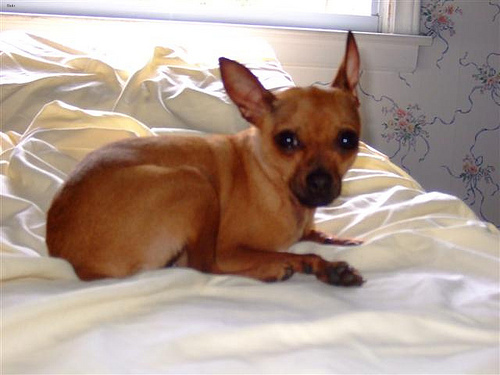

In [18]:
# from in memory version of image_embeddings
similarities = cosine_similarity(query_emb.cpu().numpy(), image_embeddings)[0]
top_idx = np.argmax(similarities)

# Show result 
all_images[top_idx].show()

## Do it the geneva way
Here we use a stateful UDF that laods the model once and then processes the image.

In [19]:
from typing import Callable
@udf(version="0.1", data_type=pa.list_(pa.float32(), 512)) 
# @udf(version="0.1", cuda=True, data_type=pa.list_(pa.float32(), 512))  # This can be done with the GPU
class GenEmbeddings(Callable):
    
    def __init__(self):
        self.is_loaded=False
                
    
    def setup(self):
        # Load OpenCLIP
        print(f"Ray worker sees torch.cuda.is_available() == {torch.cuda.is_available()}")
        self.model, _, self.preprocess = open_clip.create_model_and_transforms("ViT-B-32", pretrained="laion2b_s34b_b79k")
        self.tokenizer = open_clip.get_tokenizer("ViT-B-32")
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model = self.model.to(self.device).eval()
        self.is_loaded=True
    
    def __call__(self, image:pa.Array) -> pa.Array:    
        print(f"Ray worker sees torch.cuda.is_available() == {torch.cuda.is_available()}")
        if not self.is_loaded:
            self.setup()

        embeddings = []
        for b in image:
            image_bytes = b.as_buffer().to_pybytes()
            image_stream = io.BytesIO(image_bytes)
            img = Image.open(image_stream).convert("RGB")    
            img_tensor = self.preprocess(img).unsqueeze(0).to(self.device)
            with torch.no_grad():
                emb_tensor = self.model.encode_image(img_tensor)
                emb_tensor /= emb_tensor.norm(dim=-1, keepdim=True)
            np_emb = emb_tensor.squeeze().cpu().numpy().astype(np.float32)
            
            flat = pa.array(np_emb) # 1D float32 vector of shape (512,)
            embeddings.append(flat)            
    
        stacked = pa.FixedSizeListArray.from_arrays(pa.concat_arrays(embeddings), 512)
        return stacked

In [20]:
# We add an embedding column with the stateful UDF... (embeddings should be None)
try: 
    tbl.drop_columns(["embedding"])
except:
    pass
tbl.add_columns({"embedding": GenEmbeddings()})
tbl.to_pandas()

INFO:geneva.table:Adding column: udf={'embedding': UDF(func=<__main__.GenEmbeddings object at 0x7f6965343670>, name='GenEmbeddings', cuda=False, num_cpus=1.0, memory=None, batch_size=None, input_columns=['image'], data_type=FixedSizeListType(fixed_size_list<item: float>[512]), version='0.1', checkpoint_key='GenEmbeddings:0.1', field_metadata={})}
[2025-06-29T14:53:36Z WARN  lance::dataset::scanner] nprobes is not set because nearest has not been called yet


image  label  \
0   b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...     20   
1   b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...      1   
2   b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...     18   
3   b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...     16   
4   b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...     14   
..                                                ...    ...   
70  b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...     33   
71  b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...     14   
72  b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...     15   
73  b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...      5   
74  b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...     33   

                  image_id  label_cat_dog  file_size  \
0           Maine_Coon_204              0     342408   
1     american_bulldog_138              1     335902   
2             keeshond_112              1     424497   
3             havanese_157              1     505457   
4   german_shorthaired_132              1     235709   
..                     ...            ...        ...   
70              Sphynx_172              0     187898   
71  german_shorthaired_125              1     494021   
72      great_pyrenees_105              1     429128   
73              Bengal_176              0      90395   
74              Sphynx_160              0     380279   

                       dimensions embedding  
0   {'width': 389, 'height': 500}      None  
1   {'width': 333, 'height': 500}      None  
2   {'width': 500, 'height': 375}      None  
3   {'width': 500, 'height': 375}      None  
4   {'width': 500, 'height': 333}      None  
..                            ...       ...  
70  {'width': 500, 'height': 340}      None  
71  {'width': 500, 'height': 375}      None  
72  {'width': 500, 'height': 375}      None  
73  {'width': 300, 'height': 225}      None  
74  {'width': 500, 'height': 372}      None  

[75 rows x 7 columns]

In [21]:
%%time
# .. and then populate it with backfill if we have 
tbl.backfill("embedding")
tbl.to_pandas()

DEBUG:kubernetes.client.rest:response body: {"kind":"PodList","apiVersion":"v1","metadata":{"resourceVersion":"64706241"},"items":[]}



Cluster nodes provisioned: |           0 [00:00]

DEBUG:geneva.runners.ray.kuberay:ray cluster_resources: {'memory': 27578653492.0, 'GPU': 1.0, 'node:172.17.78.133': 1.0, 'CPU': 32.0, 'accelerator_type:RTX': 1.0, 'node:__internal_head__': 1.0, 'object_store_memory': 11819422924.0}


Workers scheduled: |           0 [00:00]

DEBUG:geneva.runners.ray.pipeline:starting worker tracker...


Workers started: 0it [00:00, ?it/s]

DEBUG:geneva.runners.ray.pipeline:starting batchtracker...


Batches checkpointed: 0it [00:00, ?it/s]

DEBUG:geneva.runners.ray.pipeline:starting fragment tracker...


Fragments written: 0it [00:00, ?it/s]

DEBUG:kubernetes.client.rest:response body: {"kind":"PodList","apiVersion":"v1","metadata":{"resourceVersion":"64706281"},"items":[]}

DEBUG:geneva.runners.ray.kuberay:ray cluster_resources: {'node:__internal_head__': 1.0, 'GPU': 1.0, 'node:172.17.78.133': 1.0, 'CPU': 32.0, 'accelerator_type:RTX': 1.0, 'memory': 27578653492.0, 'object_store_memory': 11819422924.0}
DEBUG:kubernetes.client.rest:response body: {"kind":"PodList","apiVersion":"v1","metadata":{"resourceVersion":"64706304"},"items":[]}

DEBUG:geneva.runners.ray.kuberay:ray cluster_resources: {'node:__internal_head__': 1.0, 'GPU': 1.0, 'node:172.17.78.133': 1.0, 'accelerator_type:RTX': 1.0, 'memory': 27578653492.0, 'CPU': 32.0, 'object_store_memory': 11819422924.0}
DEBUG:kubernetes.client.rest:response body: {"kind":"PodList","apiVersion":"v1","metadata":{"resourceVersion":"64706337"},"items":[]}

DEBUG:geneva.runners.ray.kuberay:ray cluster_resources: {'CPU': 32.0, 'GPU': 1.0, 'node:172.17.78.133': 1.0, 'accelerator_type:RTX'

CPU times: user 1.09 s, sys: 364 ms, total: 1.45 s
Wall time: 32.5 s


image  label  \
0   b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...     20   
1   b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...      1   
2   b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...     18   
3   b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...     16   
4   b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...     14   
..                                                ...    ...   
70  b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...     33   
71  b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...     14   
72  b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...     15   
73  b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...      5   
74  b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...     33   

                  image_id  label_cat_dog  file_size  \
0           Maine_Coon_204              0     342408   
1     american_bulldog_138              1     335902   
2             keeshond_112              1     424497   
3             havanese_157              1     505457   
4   german_shorthaired_132              1     235709   
..                     ...            ...        ...   
70              Sphynx_172              0     187898   
71  german_shorthaired_125              1     494021   
72      great_pyrenees_105              1     429128   
73              Bengal_176              0      90395   
74              Sphynx_160              0     380279   

                       dimensions  \
0   {'width': 389, 'height': 500}   
1   {'width': 333, 'height': 500}   
2   {'width': 500, 'height': 375}   
3   {'width': 500, 'height': 375}   
4   {'width': 500, 'height': 333}   
..                            ...   
70  {'width': 500, 'height': 340}   
71  {'width': 500, 'height': 375}   
72  {'width': 500, 'height': 375}   
73  {'width': 300, 'height': 225}   
74  {'width': 500, 'height': 372}   

                                            embedding  
0   [0.007883274, 0.086084016, -0.1477047, -0.0490...  
1   [-0.014589928, 0.052585304, -0.109454, 0.00707...  
2   [-0.016874198, 0.06102884, -0.098882556, -0.02...  
3   [-0.022896344, 0.08523144, -0.08575478, -0.014...  
4   [-0.036996305, 0.06692373, -0.09436133, 0.0349...  
..                                                ...  
70  [-0.006845067, -0.04410822, -0.09187488, -0.06...  
71  [0.008227378, 0.002013377, 0.0029814956, 0.015...  
72  [-0.0336172, 0.09910978, -0.14113168, 0.007343...  
73  [0.026781831, -0.08819837, 0.04490605, -0.0718...  
74  [-0.010460918, 0.1207285, -0.09718543, 0.02053...  

[75 rows x 7 columns]

## Do a lancedb vector search
Now we do the lance native vector search to find the image based on text.

In [22]:
rows = tbl.search(query_emb.tolist(), 'embedding').to_list()
len(rows)

10

# do a lancedb search
import lancedb
lc = lancedb.connect(GENEVA_DB_PATH)
lt = lc.open_table("images")
rows = lt.search(query_emb.tolist(), 'embedding').to_list()
len(rows)

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 65536


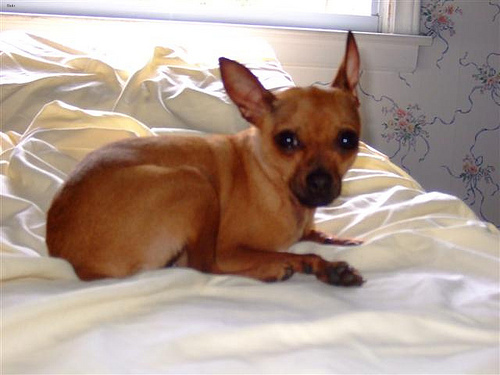

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 65536


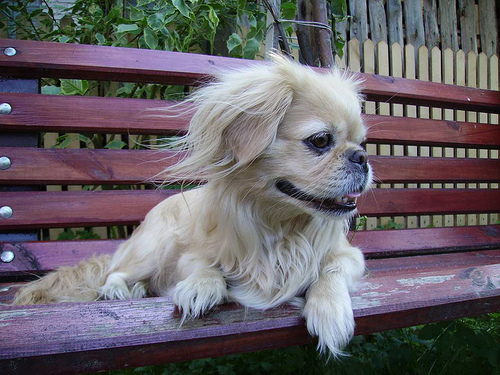

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 65536


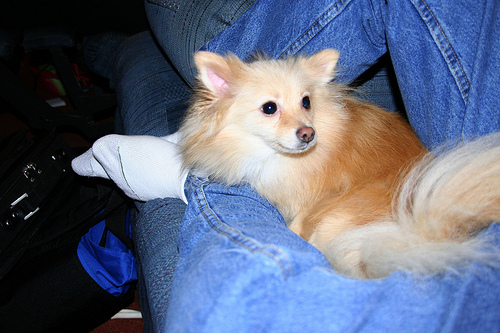

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 65536


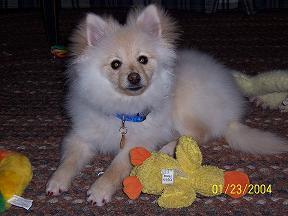

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 65536


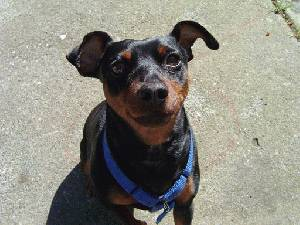

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 65536


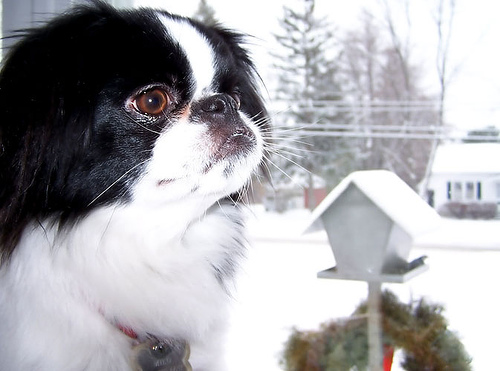

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 65536


DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'iCCP' 41 292
DEBUG:PIL.PngImagePlugin:iCCP profile name b'ICC Profile'
DEBUG:PIL.PngImagePlugin:Compression method 0
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 345 65536


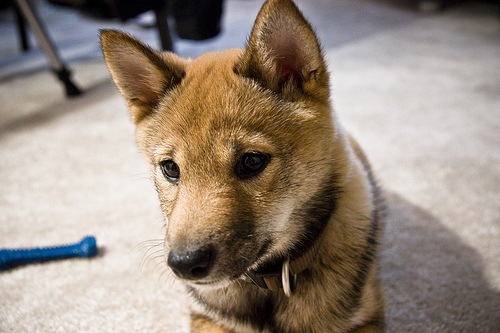

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 65536


DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 65536


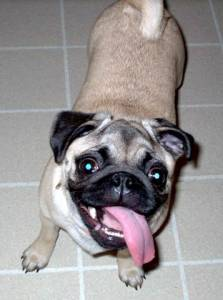

In [23]:
# yup, same picture!
for r in rows:
    image_bytes = r["image"]
    image_stream = io.BytesIO(image_bytes)
    img = Image.open(image_stream).convert("RGB") 
    display(img)

# Use Blip to generate a caption

Here we use the blip image captioning model to generate text captions

In [24]:
!uv pip install transformers

/home/jmhsieh/proj/geneva/.venv/lib/python3.10/site-packages/lancedb/__init__.py:220: UserWarning: lance is not fork-safe. If you are using multiprocessing, use spawn instead.
  warnings.warn(
/home/jmhsieh/proj/geneva/.venv/lib/python3.10/site-packages/lance/__init__.py:168: UserWarning: lance is not fork-safe. If you are using multiprocessing, use spawn instead.
  warnings.warn(


Using Python 3.10.16 environment at: /home/jmhsieh/proj/geneva/.venv
Audited 1 package in 4ms


In [25]:
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import torch

def generate_caption(image): 
    # Load the processor and model (using the base model variant)
    processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
    model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

    # Open an image using PIL
    raw_image = image.convert("RGB")
    #     raw_image = image.convert("RGB").resize((384,384))

    
    # Preprocess the image
    #     inputs = processor([raw_image], return_tensors="pt", do_resize=False)
    inputs = processor([raw_image], return_tensors="pt")

    # If using a GPU with 12GB VRAM, move model and inputs to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Generate caption (you can adjust generation parameters as needed)
    output_ids = model.generate(**inputs, max_length=50)
    caption = processor.decode(output_ids[0], skip_special_tokens=True)

    return caption

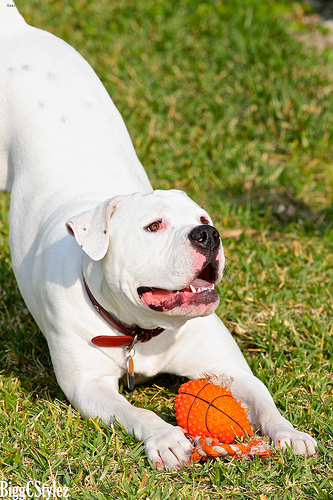

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


'a white dog playing with a ball'

In [26]:
# Let's do a test of the function. 
display(all_images[1])
generate_caption(all_images[1])

## Let's wrap the function as a udf and apply to all

In [27]:
import torch
import pyarrow as pa

@udf(version="blip", cuda=True)
def caption_udf(image:bytes) -> str: 
    try:
        import geneva

        # load images and prepare for inputs
        image_stream = io.BytesIO(image)
        pil_image = Image.open(image_stream).convert("RGB")        
        answer = generate_caption(pil_image)
        return answer
    except:
        raise ValueException("problem in UDF") from e

In [28]:
try:
    tbl.drop_columns(["caption_blip"])
except:
    pass

tbl.add_columns({"caption_blip": caption_udf})

INFO:geneva.table:Adding column: udf={'caption_blip': UDF(func=<function caption_udf at 0x7f64381c2a70>, name='caption_udf', cuda=True, num_cpus=1.0, memory=None, batch_size=None, input_columns=['image'], data_type=DataType(string), version='blip', checkpoint_key='caption_udf:blip', field_metadata={})}


In [29]:
tbl.to_pandas()

[2025-06-29T14:54:14Z WARN  lance::dataset::scanner] nprobes is not set because nearest has not been called yet


image  label  \
0   b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...     20   
1   b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...      1   
2   b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...     18   
3   b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...     16   
4   b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...     14   
..                                                ...    ...   
70  b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...     33   
71  b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...     14   
72  b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...     15   
73  b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...      5   
74  b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...     33   

                  image_id  label_cat_dog  file_size  \
0           Maine_Coon_204              0     342408   
1     american_bulldog_138              1     335902   
2             keeshond_112              1     424497   
3             havanese_157              1     505457   
4   german_shorthaired_132              1     235709   
..                     ...            ...        ...   
70              Sphynx_172              0     187898   
71  german_shorthaired_125              1     494021   
72      great_pyrenees_105              1     429128   
73              Bengal_176              0      90395   
74              Sphynx_160              0     380279   

                       dimensions  \
0   {'width': 389, 'height': 500}   
1   {'width': 333, 'height': 500}   
2   {'width': 500, 'height': 375}   
3   {'width': 500, 'height': 375}   
4   {'width': 500, 'height': 333}   
..                            ...   
70  {'width': 500, 'height': 340}   
71  {'width': 500, 'height': 375}   
72  {'width': 500, 'height': 375}   
73  {'width': 300, 'height': 225}   
74  {'width': 500, 'height': 372}   

                                            embedding caption_blip  
0   [0.007883274, 0.086084016, -0.1477047, -0.0490...         None  
1   [-0.014589928, 0.052585304, -0.109454, 0.00707...         None  
2   [-0.016874198, 0.06102884, -0.098882556, -0.02...         None  
3   [-0.022896344, 0.08523144, -0.08575478, -0.014...         None  
4   [-0.036996305, 0.06692373, -0.09436133, 0.0349...         None  
..                                                ...          ...  
70  [-0.006845067, -0.04410822, -0.09187488, -0.06...         None  
71  [0.008227378, 0.002013377, 0.0029814956, 0.015...         None  
72  [-0.0336172, 0.09910978, -0.14113168, 0.007343...         None  
73  [0.026781831, -0.08819837, 0.04490605, -0.0718...         None  
74  [-0.010460918, 0.1207285, -0.09718543, 0.02053...         None  

[75 rows x 8 columns]

In [30]:
%%time
# And backfill to get captions if we have a gpu
if has_gpu:
    tbl.backfill("caption_blip")
tbl.to_pandas()

DEBUG:kubernetes.client.rest:response body: {"kind":"PodList","apiVersion":"v1","metadata":{"resourceVersion":"64706697"},"items":[]}



Cluster nodes provisioned: |           0 [00:00]

DEBUG:geneva.runners.ray.kuberay:ray cluster_resources: {'node:__internal_head__': 1.0, 'GPU': 1.0, 'node:172.17.78.133': 1.0, 'CPU': 32.0, 'memory': 27578653492.0, 'accelerator_type:RTX': 1.0, 'object_store_memory': 11819422924.0}


Workers scheduled: |           0 [00:00]

DEBUG:geneva.runners.ray.pipeline:starting worker tracker...


Workers started: 0it [00:00, ?it/s]

DEBUG:geneva.runners.ray.pipeline:starting batchtracker...


Batches checkpointed:   0%|          | 0/3 [00:00<?, ?it/s]

DEBUG:geneva.runners.ray.pipeline:starting fragment tracker...


Fragments written:   0%|          | 0/3 [00:00<?, ?it/s]

DEBUG:kubernetes.client.rest:response body: {"kind":"PodList","apiVersion":"v1","metadata":{"resourceVersion":"64706742"},"items":[]}

DEBUG:geneva.runners.ray.kuberay:ray cluster_resources: {'node:__internal_head__': 1.0, 'GPU': 1.0, 'node:172.17.78.133': 1.0, 'CPU': 32.0, 'memory': 27578653492.0, 'accelerator_type:RTX': 1.0, 'object_store_memory': 11819422924.0}
DEBUG:kubernetes.client.rest:response body: {"kind":"PodList","apiVersion":"v1","metadata":{"resourceVersion":"64706770"},"items":[]}

DEBUG:geneva.runners.ray.kuberay:ray cluster_resources: {'node:__internal_head__': 1.0, 'GPU': 1.0, 'node:172.17.78.133': 1.0, 'CPU': 32.0, 'accelerator_type:RTX': 1.0, 'memory': 27578653492.0, 'object_store_memory': 11819422924.0}
DEBUG:kubernetes.client.rest:response body: {"kind":"PodList","apiVersion":"v1","metadata":{"resourceVersion":"64706795"},"items":[]}

DEBUG:geneva.runners.ray.kuberay:ray cluster_resources: {'CPU': 32.0, 'GPU': 1.0, 'node:172.17.78.133': 1.0, 'memory': 27578653492.

CPU times: user 9.76 s, sys: 789 ms, total: 10.6 s
Wall time: 3min 46s


image  label  \
0   b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...     20   
1   b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...      1   
2   b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...     18   
3   b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...     16   
4   b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...     14   
..                                                ...    ...   
70  b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...     33   
71  b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...     14   
72  b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...     15   
73  b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...      5   
74  b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...     33   

                  image_id  label_cat_dog  file_size  \
0           Maine_Coon_204              0     342408   
1     american_bulldog_138              1     335902   
2             keeshond_112              1     424497   
3             havanese_157              1     505457   
4   german_shorthaired_132              1     235709   
..                     ...            ...        ...   
70              Sphynx_172              0     187898   
71  german_shorthaired_125              1     494021   
72      great_pyrenees_105              1     429128   
73              Bengal_176              0      90395   
74              Sphynx_160              0     380279   

                       dimensions  \
0   {'width': 389, 'height': 500}   
1   {'width': 333, 'height': 500}   
2   {'width': 500, 'height': 375}   
3   {'width': 500, 'height': 375}   
4   {'width': 500, 'height': 333}   
..                            ...   
70  {'width': 500, 'height': 340}   
71  {'width': 500, 'height': 375}   
72  {'width': 500, 'height': 375}   
73  {'width': 300, 'height': 225}   
74  {'width': 500, 'height': 372}   

                                            embedding  \
0   [0.007883274, 0.086084016, -0.1477047, -0.0490...   
1   [-0.014589928, 0.052585304, -0.109454, 0.00707...   
2   [-0.016874198, 0.06102884, -0.098882556, -0.02...   
3   [-0.022896344, 0.08523144, -0.08575478, -0.014...   
4   [-0.036996305, 0.06692373, -0.09436133, 0.0349...   
..                                                ...   
70  [-0.006845067, -0.04410822, -0.09187488, -0.06...   
71  [0.008227378, 0.002013377, 0.0029814956, 0.015...   
72  [-0.0336172, 0.09910978, -0.14113168, 0.007343...   
73  [0.026781831, -0.08819837, 0.04490605, -0.0718...   
74  [-0.010460918, 0.1207285, -0.09718543, 0.02053...   

                                  caption_blip  
0                           a fluffy white cat  
1              a white dog playing with a ball  
2                    a dog laying in the grass  
3                    a dog laying in the grass  
4                   a dog standing in the snow  
..                                         ...  
70            a cat is laying on a red blanket  
71                  a dog sitting in the grass  
72                   a dog laying in the grass  
73                     a cat sitting on a bike  
74  sphyhyhyhyhyhyhyhyhyhyhyhyhyhyhyhyhyhyhyhy  

[75 rows x 8 columns]

## Let's optimize with a stateful udf


In [31]:
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import torch
import pyarrow as pa

@udf(cuda=True)
class GenCaption:
    def __init__(self):
        self.is_loaded=False

    def setup(self):
        # Load the processor and model (using the base model variant)
        self.processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
        self.model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
        self.is_loaded=True
        # If using a GPU with 12GB VRAM, move model and inputs to GPU if available
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(device)
        self.is_loaded = True


    def __call__(self, image:bytes) -> str:
        try:
            import geneva

            if not self.is_loaded:
                self.setup()

            # load images and prepare for inputs
            image_stream = io.BytesIO(image)
            raw_image = Image.open(image_stream).convert("RGB")

            # Preprocess the image
            inputs = self.processor([raw_image], return_tensors="pt")
            inputs = {k: v.to(self.device) for k, v in inputs.items()}

            # Generate caption (you can adjust generation parameters as needed)
            output_ids = self.model.generate(**inputs, max_length=50)
            caption = self.processor.decode(output_ids[0], skip_special_tokens=True)
            return caption

        except:
            raise ValueException("problem in UDF") from e




In [32]:
try:
    tbl.drop_columns(["caption_blip_v2"])
except:
    pass

tbl.add_columns({"caption_blip_v2": GenCaption()})

INFO:geneva.table:Adding column: udf={'caption_blip_v2': UDF(func=<__main__.GenCaption object at 0x7f641e4a1ae0>, name='GenCaption', cuda=True, num_cpus=1.0, memory=None, batch_size=None, input_columns=['image'], data_type=DataType(string), version='71f73a35d8db496f4a515c89ad6f62af', checkpoint_key='GenCaption:71f73a35d8db496f4a515c89ad6f62af', field_metadata={})}


In [33]:
%%time
# And backfill to get captions if we have a gpu
if has_gpu:
    tbl.backfill("caption_blip_v2")
tbl.to_pandas()

DEBUG:kubernetes.client.rest:response body: {"kind":"PodList","apiVersion":"v1","metadata":{"resourceVersion":"64709445"},"items":[]}



Cluster nodes provisioned: |           0 [00:00]

DEBUG:geneva.runners.ray.kuberay:ray cluster_resources: {'memory': 27578653492.0, 'GPU': 1.0, 'node:172.17.78.133': 1.0, 'accelerator_type:RTX': 1.0, 'CPU': 32.0, 'node:__internal_head__': 1.0, 'object_store_memory': 11819422924.0}


Workers scheduled: |           0 [00:00]

DEBUG:geneva.runners.ray.pipeline:starting worker tracker...


Workers started: 0it [00:00, ?it/s]

DEBUG:geneva.runners.ray.pipeline:starting batchtracker...


Batches checkpointed:   0%|          | 0/3 [00:00<?, ?it/s]

DEBUG:geneva.runners.ray.pipeline:starting fragment tracker...


Fragments written:   0%|          | 0/3 [00:00<?, ?it/s]

DEBUG:kubernetes.client.rest:response body: {"kind":"PodList","apiVersion":"v1","metadata":{"resourceVersion":"64709483"},"items":[]}

DEBUG:geneva.runners.ray.kuberay:ray cluster_resources: {'memory': 27578653492.0, 'GPU': 1.0, 'node:172.17.78.133': 1.0, 'accelerator_type:RTX': 1.0, 'node:__internal_head__': 1.0, 'CPU': 32.0, 'object_store_memory': 11819422924.0}
DEBUG:kubernetes.client.rest:response body: {"kind":"PodList","apiVersion":"v1","metadata":{"resourceVersion":"64709510"},"items":[]}

DEBUG:geneva.runners.ray.kuberay:ray cluster_resources: {'CPU': 32.0, 'GPU': 1.0, 'node:172.17.78.133': 1.0, 'memory': 27578653492.0, 'accelerator_type:RTX': 1.0, 'node:__internal_head__': 1.0, 'object_store_memory': 11819422924.0}
DEBUG:kubernetes.client.rest:response body: {"kind":"PodList","apiVersion":"v1","metadata":{"resourceVersion":"64709535"},"items":[]}

DEBUG:geneva.runners.ray.kuberay:ray cluster_resources: {'node:__internal_head__': 1.0, 'GPU': 1.0, 'node:172.17.78.133': 1.0, 'acc

CPU times: user 1.66 s, sys: 377 ms, total: 2.04 s
Wall time: 1min 3s


image  label  \
0   b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...     20   
1   b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...      1   
2   b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...     18   
3   b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...     16   
4   b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...     14   
..                                                ...    ...   
70  b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...     33   
71  b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...     14   
72  b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...     15   
73  b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...      5   
74  b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...     33   

                  image_id  label_cat_dog  file_size  \
0           Maine_Coon_204              0     342408   
1     american_bulldog_138              1     335902   
2             keeshond_112              1     424497   
3             havanese_157              1     505457   
4   german_shorthaired_132              1     235709   
..                     ...            ...        ...   
70              Sphynx_172              0     187898   
71  german_shorthaired_125              1     494021   
72      great_pyrenees_105              1     429128   
73              Bengal_176              0      90395   
74              Sphynx_160              0     380279   

                       dimensions  \
0   {'width': 389, 'height': 500}   
1   {'width': 333, 'height': 500}   
2   {'width': 500, 'height': 375}   
3   {'width': 500, 'height': 375}   
4   {'width': 500, 'height': 333}   
..                            ...   
70  {'width': 500, 'height': 340}   
71  {'width': 500, 'height': 375}   
72  {'width': 500, 'height': 375}   
73  {'width': 300, 'height': 225}   
74  {'width': 500, 'height': 372}   

                                            embedding  \
0   [0.007883274, 0.086084016, -0.1477047, -0.0490...   
1   [-0.014589928, 0.052585304, -0.109454, 0.00707...   
2   [-0.016874198, 0.06102884, -0.098882556, -0.02...   
3   [-0.022896344, 0.08523144, -0.08575478, -0.014...   
4   [-0.036996305, 0.06692373, -0.09436133, 0.0349...   
..                                                ...   
70  [-0.006845067, -0.04410822, -0.09187488, -0.06...   
71  [0.008227378, 0.002013377, 0.0029814956, 0.015...   
72  [-0.0336172, 0.09910978, -0.14113168, 0.007343...   
73  [0.026781831, -0.08819837, 0.04490605, -0.0718...   
74  [-0.010460918, 0.1207285, -0.09718543, 0.02053...   

                                  caption_blip  \
0                           a fluffy white cat   
1              a white dog playing with a ball   
2                    a dog laying in the grass   
3                    a dog laying in the grass   
4                   a dog standing in the snow   
..                                         ...   
70            a cat is laying on a red blanket   
71                  a dog sitting in the grass   
72                   a dog laying in the grass   
73                     a cat sitting on a bike   
74  sphyhyhyhyhyhyhyhyhyhyhyhyhyhyhyhyhyhyhyhy   

                               caption_blip_v2  
0                           a fluffy white cat  
1              a white dog playing with a ball  
2                    a dog laying in the grass  
3                    a dog laying in the grass  
4                   a dog standing in the snow  
..                                         ...  
70            a cat is laying on a red blanket  
71                  a dog sitting in the grass  
72                   a dog laying in the grass  
73                     a cat sitting on a bike  
74  sphyhyhyhyhyhyhyhyhyhyhyhyhyhyhyhyhyhyhyhy  

[75 rows x 9 columns]

# Shutdown

In [34]:
ray.shutdown()